In [91]:
# script to read in awas data for flights 5 - 14
# remove samples in SH, near guam, and where tracer values < 0 

In [1]:
import xarray as xr
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
### ---------------------- READ IN DATA  ---------------------- ###
# path to data
mypath = '/Volumes/scdrive2/contrast_merge_data/contrast_awas_merge/*.nc'

# read in merge all flights 
contrast_init = xr.open_mfdataset(mypath, combine='by_coords')
# drop the variables without category metadata (no instrument)
contrast_init = contrast_init.drop('DOAS_BrO').drop('DOAS_delta_BrO')

# change coordinate from "Time" to "Time_UTC"
#contrast_init.coords['Time_UTC'] = (contrast_init.Time_UTC)

In [3]:
### --- what instruments do each data variable come from?
#for ii in contrast_init.data_vars:
#    print(contrast_init[ii].attrs['Category'])

### --- print each awas measured tracer 
for ii in contrast_init.data_vars:
    if contrast_init[ii].attrs['Category'] == 'AWAS':
        print(contrast_init[ii].long_name)

C2H6_Ethane
C2H2_Ethyne
C3H8_Propane
C4H10_Isobutane
C4H10_nButane
C5H12_Isopentane
C5H12_nPentane
C5H8_Isoprene
C6H6_Benzene
OCS_Carbonyl_sulfide
C2H6S_Dimethyl_sulfide
CCl2F2_CFC_12
CCl3F_CFC_11
CCl2FCCl2F_CFC112
CCl3CClF2_CFC_112a
C2Cl3F3_CFC_113
C2Cl2F4_CFC_114
CHClF2_HCFC_22
CH3CClF2_HCFC_142b
CH3CCl2F_HCFC_141b
CH2FCF3_HFC_134a
C4H5F5_HFC365mfc
CH3Cl_Methyl_chloride
CH3Br_Methyl_bromide
CH3I_Methyl_iodide
CH2Cl2_Methylene_chloride
CHCl3_Chloroform
CH3CCl3_Methyl_chloroform
CCl4_Carbon_tetrachloride
C2H4Cl2_1_2_Dichloroethane
C2HCl3_Trichloroethylene
C2Cl4_Tetrachloroethylene
C6H5Cl_Chlorobenzene
CBrClF2_Halon_1211
C2Br2F4_Halon_2402
CH2BrCl_Bromochloromethane
CH2Br2_Methylene_bromide
CHBrCl2_Bromodichloromethane
CHBr2Cl_Dibromochloromethane
CHBr3_Bromoform
CH3ONO2_Methyl_nitrate
C2H5ONO2_Ethyl_nitrate
C3H7NO3_Isopropyl_nitrate
C4H9NO3_2_Butyl_nitrate
C4H9NO3_n_Butyl_nitrate
C5H11NO3_3_pentyl_nitrate
C5H11NO3_2_pentyl_nitrate


In [4]:
### --- subset the data so that we only keep awas tracers that we want 
# empyt dataset to fill with awas data 
awas_init = xr.Dataset()
# fill with anything that has 'awas' as the category
for ii in contrast_init.data_vars:
    if contrast_init[ii].attrs['Category'] == 'AWAS':
        awas_init[ii] = contrast_init[ii]
        
### --- remove any AWAS tracers we dont use in TTS paper (40 awas total used)
awas_trc_prelim = awas_init.drop('C5H12_Isopentane').drop('C5H8_Isoprene'). \
    drop('CH3I_Methyl_iodide'). \
    drop('C2HCl3_Trichloroethylene').drop('CH3ONO2_Methyl_nitrate'). \
    drop('C5H11NO3_3_pentyl_nitrate').drop('C5H11NO3_2_pentyl_nitrate')
print(len(awas_trc_prelim))

### --- awas aircraft parameters and location 
awas_param_init = xr.merge([contrast_init.GGALT, contrast_init.GGLAT, contrast_init.GGLON, 
                           contrast_init.Time_UTC])
awas_param_init               
    #contrast_init.WIC, contrast_init.PALT, contrast_init.RHUM])

40


<xarray.Dataset>
Dimensions:   (Time: 597)
Coordinates:
  * Time      (Time) datetime64[ns] 2014-01-22T00:20:25 ... 2014-02-22T08:51:48
Data variables:
    GGALT     (Time) float32 dask.array<chunksize=(59,), meta=np.ndarray>
    GGLAT     (Time) float32 dask.array<chunksize=(59,), meta=np.ndarray>
    GGLON     (Time) float32 dask.array<chunksize=(59,), meta=np.ndarray>
    Time_UTC  (Time) datetime64[ns] dask.array<chunksize=(59,), meta=np.ndarray>

In [5]:
### ---------------------- CONFINE TO NH  ---------------------- ###

# take a look at where values for latitude lie - NH, SH, or nan
#southhem = np.where(awas_param_init.GGLAT.values < 0)
northhem = np.where(awas_param_init.GGLAT.values > 0)
print(np.size(northhem))
#nullinit = np.isnan(awas_param_init.GGLAT.values).sum()

# keep only NH values, rewrite to awas_param 
awas_param_noblcorr = xr.Dataset()
for ii in awas_param_init.data_vars:
    param = awas_param_init[ii]
    nh_only = param[northhem].values 
    awas_param_noblcorr[ii] = nh_only
    
# select NH only for all tracers 
awas_trc_nh = xr.Dataset()
for ii in awas_trc_prelim.data_vars:
    trc = awas_trc_prelim[ii]
    nh_only = trc[northhem]
    awas_trc_nh[ii] = nh_only

527


//anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [6]:
### ---------------------- REMOVE NULL VALUES, < 0 VALUES ---------------------- ###
# ignore comparison to nan warnings (for where trc<0)
np.warnings.filterwarnings('ignore')

### null values (-777, -888), make = nan 
awas_trc_noblcorr = xr.Dataset()
for ii in awas_trc_nh.data_vars:
    trc = awas_trc_nh[ii]
    trc_vals = trc.values
    
    # -------- locations for fills
    llod = awas_trc_nh[ii].attrs['LLOD']
    ulod = awas_trc_nh[ii].attrs['ULOD']
    
    # -------- make those locations nan and save to variable 
    #trc_masked = trc.where((trc.values != llod) & (trc.values != ulod))
    trc_masked = np.ma.masked_where(trc_vals < 0, trc_vals)
    trc_masked = np.ma.masked_where(trc_vals == llod, trc_masked)
    trc_masked = np.ma.masked_where(trc_vals == ulod, trc_masked)
    trc.values = trc_masked 
    
    awas_trc_noblcorr[ii] = trc

In [7]:
### ---------------------- ADD LIFETIMES AS AN ATTRIBUTE ---------------------- ###
### --- add attribute to each (BL, tropo, and UT lifetimes)
# read in from xls file to make dataframe
mypath2 = '/Volumes/scdrive2/TTS_2020/contrast_readin/awas/awas_lifetimes_12162019.xlsx'
awas_lifetimes = pd.read_excel(mypath2)

# fill in lifetime attributes using that dataframe 
for ii in enumerate(awas_trc_noblcorr.data_vars):
    myind = ii[0]
    trc = ii[1]
    awas_trc_noblcorr[trc].attrs['BL_lifetime'] = awas_lifetimes['BL_tau'][myind]
    awas_trc_noblcorr[trc].attrs['UT_lifetime'] = awas_lifetimes['UT_tau'][myind]
    awas_trc_noblcorr[trc].attrs['TROPO_lifetime'] = awas_lifetimes['TROPO_tau'][myind]

In [8]:
### ---------------------- REMOVE BL SAMPLES NEAR GUAM ---------------------- ###
# ~111 km/degree lat and ~108 km/degree long
# so this is about 11 km around guam 
# https://www.johndcook.com/how_big_is_a_degree.html
guam_coord = [13.4, 144.8]
cut = 0.16
print((111*0.16), (108*0.16))
guam_lat_cuts = [guam_coord[0]-cut, guam_coord[0]+cut]
guam_lon_cuts = [guam_coord[1]-cut, guam_coord[1]+cut]

# get the regions near guam to mask out and altitudes (not BL)
null_lat = np.where((awas_param_noblcorr.GGLAT > guam_lat_cuts[0]) 
                    & (awas_param_noblcorr.GGLAT < guam_lat_cuts[1]))
null_lon = np.where((awas_param_noblcorr.GGLON > guam_lon_cuts[0]) 
                    & (awas_param_noblcorr.GGLON < guam_lon_cuts[1]))
null_alt = np.where((awas_param_noblcorr.GGALT < 4000))

# get intersection, index list to mask 
near_guam = np.intersect1d(null_lat, null_lon, null_alt)

# get the opposite of that index, NOT near guam 
#not_guam = np.arange(0, len(toga_param.GGALT.values), dtype = float)
#not_guam[near_guam]=np.nan

not_guam = np.arange(0, len(awas_param_noblcorr.GGALT.values))
not_guam = np.delete(not_guam, near_guam)

17.76 17.28


In [9]:
# keep only non-guam values - AIRCRAFT PARAM 
awas_param = xr.Dataset()
for ii in awas_param_noblcorr.coords:
    param = awas_param_noblcorr[ii]
    param_noguam = param[not_guam].values 
    awas_param[ii] = param_noguam

# keep only non-guam values - TRACERS 
awas_trc = xr.Dataset()
for ii in awas_trc_noblcorr.data_vars:
    trc = awas_trc_noblcorr[ii]
    trc_noguam = trc[not_guam]
    awas_trc[ii] = trc_noguam


In [10]:
### ---------------------- ADD AC PARAMETERS AS COORDINATES ---------------------- ###
# ---- add parameters as coordinates 
for ii in awas_param.coords:
    my_coord = awas_param[ii]
    awas_trc.coords[ii] = my_coord

In [11]:
awas_trc

<xarray.Dataset>
Dimensions:                       (GGALT: 525, GGLAT: 525, GGLON: 525, Time: 525, Time_UTC: 525)
Coordinates:
  * Time                          (Time) datetime64[ns] 2014-01-22T00:20:25 ... 2014-02-22T08:51:48
  * GGALT                         (GGALT) float32 3846.6377 ... 15235.298
  * GGLAT                         (GGLAT) float32 13.294079 ... 9.360893
  * GGLON                         (GGLON) float32 145.20465 ... 145.31483
  * Time_UTC                      (Time_UTC) datetime64[ns] 2014-01-22T00:20:30 ... 2014-02-22T08:52:05
Data variables:
    C2H6_Ethane                   (Time) float32 447.0 436.0 ... 480.0 483.0
    C2H2_Ethyne                   (Time) float32 81.0 60.0 52.0 ... 48.0 47.0
    C3H8_Propane                  (Time) float32 31.0 29.0 26.0 ... 35.0 26.0
    C4H10_Isobutane               (Time) float32 4.0 1.9 1.9 1.9 ... 1.4 1.1 1.4
    C4H10_nButane                 (Time) float32 7.1 4.3 3.7 3.2 ... 1.9 2.4 1.9
    C5H12_nPentane                (Ti

In [13]:
### ---------------------- SAVE ---------------------- ###
### pickle it! 
awas_trc.to_netcdf(path = '/Volumes/scdrive2/TTS_2020/contrast_readin/awas/awas_trace_gases.nc')
print ('finished saving tracers')

finished saving tracers


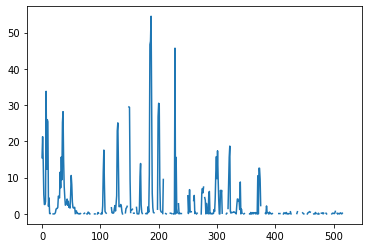

In [103]:
plt.plot(awas_trc.C2H6S_Dimethyl_sulfide)

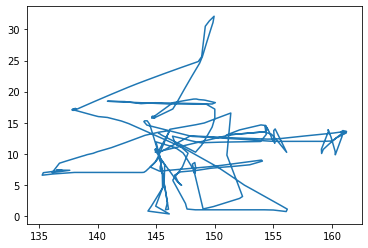

In [104]:
plt.plot(awas_trc.GGLON, awas_trc.GGLAT)